In [146]:
import matplotlib.pyplot as plt
from functions import *
from audio_class import Audio
import os
from pandas import DataFrame

In [ ]:
SAMPLE_RATE = 44100
FREQUENCY_RANGE = (50, 2500)

piano_single_notes = ['piano C2.wav', 'piano C#2.wav', 'piano D2.wav', 'piano D#2.wav', 'piano E2.wav', 'piano F2.wav',
                      'piano F#2.wav', 'piano G2.wav', 'piano G#2.wav', 'piano A2.wav', 'piano A#2.wav', 'piano H2.wav',
                      'piano C3.wav', 'piano C#3.wav', 'piano D3.wav', 'piano D#3.wav', 'piano E3.wav', 'piano F3.wav',
                      'piano F#3.wav', 'piano G3.wav', 'piano G#3.wav', 'piano A3.wav', 'piano A#3.wav', 'piano H3.wav',
                      'piano C4.wav', 'piano C#4.wav', 'piano D4.wav', 'piano D#4.wav', 'piano E4.wav', 'piano F4.wav',
                      'piano F#4.wav', 'piano G4.wav', 'piano G#4.wav', 'piano A4.wav', 'piano A#4.wav', 'piano H4.wav',
                      'piano C5.wav', 'piano C#5.wav', 'piano D5.wav', 'piano D#5.wav', 'piano E5.wav', 'piano F5.wav',
                      'piano F#5.wav', 'piano G5.wav', 'piano G#5.wav', 'piano A5.wav', 'piano A#5.wav', 'piano H5.wav',
                      'piano C6.wav', 'piano C#6.wav', 'piano D6.wav', 'piano D#6.wav', 'piano E6.wav', 'piano F6.wav',
                      'piano F#6.wav', 'piano G6.wav', 'piano G#6.wav', 'piano A6.wav', 'piano A#6.wav', 'piano H6.wav',
                      'piano C7.wav']

sax_single_notes = ["sax A# small.wav", "sax H small.wav", "sax C1.wav", "sax C#1.wav", "sax D1.wav", "sax D#1.wav",
                    "sax E1.wav", "sax F1.wav", "sax F#1.wav", "sax G1.wav", "sax G#1.wav", "sax A1.wav", "sax A#1.wav",
                    "sax H1.wav", "sax C2.wav", "sax C#2.wav", "sax D2.wav", "sax D#2.wav", "sax E2.wav", "sax F2.wav",
                    "sax F#2.wav", "sax G2.wav", "sax G#2.wav", "sax A2.wav", "sax A#2.wav", "sax H2.wav", "sax C3.wav",
                    "sax C#3.wav", "sax D3.wav", "sax D#3.wav", "sax E3.wav", "sax F3.wav", "sax F#3.wav"]

# Test I - analiza pojedynczych dźwięków

In [178]:
directory = os.getcwd()
audio_path_sax = directory + '\Audio\sax\single notes\\'
audio_path_piano = directory + '\Audio\piano\single notes\\'
template_sax = sax_single_notes
template_piano = piano_single_notes

notes_piano = librosa.midi_to_note(np.arange(36, 97))
frequencies_piano = librosa.midi_to_hz(np.arange(36, 97)).round(3)

notes_sax = librosa.midi_to_note(np.arange(49, 82))
frequencies_sax = librosa.midi_to_hz(np.arange(49, 82)).round(3)

SAMPLE_RATE = 44100
FREQUENCY_RANGE = (50, 2500)

def find_f0(template, audio_path, hop_size, window_size):
    frequencies = np.array([])
    for name in template:
        actual_path = audio_path + name
        # CREATE INSTANCE OF "Audio" CLASS
        audio_file = Audio(audio_path=actual_path, audio_name=name, hop_size=hop_size, window_size=window_size)
        y, sr = librosa.load(actual_path, sr=SAMPLE_RATE)

        # DETECT ONSETS IN AUDIO FILE
        audio_file.amplitude_filter(top_db=top_db)
        audio_file.highpass_filter(freq=50)

        onsets = audio_file.detect_onsets(aggregate=np.mean)
        audio_file.filter_onsets()
        onsets = audio_file.onsets
        # DIVIDE SIGNAL INTO FRAMES FROM ONSET TO ONSET;
        onset_frames = audio_file.divide_into_onset_frames(onsets=onsets)

        notes_duration_idx, rests_duration_idx = audio_file.find_durations(onset_frames=onset_frames,
                                                                           onsets=onsets,
                                                                           top_db=top_db)
        # FIND F0 FREQUENCY
        note_frames = []
        for note_duration in notes_duration_idx:
            first_idx, second_idx = note_duration
            note = audio_file.audio_data[first_idx:second_idx]
            note_frames.append(note)
        freq = audio_file.find_frequencies(note_frames=note_frames)
        freq = freq.round(3)
        if len(freq) == 2:
            frequencies = np.append(frequencies, freq[1])
        else:
            frequencies = np.append(frequencies, freq[0])
    return frequencies


def save_results(filename: str, notes, frequencies, template, found_frequencies):
    df = DataFrame(
        {'Note': notes, 'Frequency [Hz]': frequencies, "Audio file": template,
         "Found frequency [Hz]": found_frequencies.round(2)})
    error = np.abs(df['Frequency [Hz]'] - df['Found frequency [Hz]'])
    percentage_error = ((error / frequencies) * 100)
    df['Error'] = error.round(2)
    df['Error [%]'] = percentage_error.round(2)
    status = []
    for i in range(len(notes)):
        if i == len(frequencies) - 1:
            if error[i] > np.abs(frequencies[i] - frequencies[i - 1]):
                status.append('bad')
            else:
                status.append('good')
        else:
            if error[i] > np.abs(frequencies[i + 1] - frequencies[i]):
                status.append('bad')
            else:
                status.append('good')
    df['Status'] = status
    return df

hop_size = 512
top_db = 20

window_sizes = [1024, 2048, 4096, 8192]
window_sizes = np.arange(1024, 8704, 512)
sax_ac = []
piano_ac = []
for window_size in window_sizes:

    found_freq_piano = find_f0(template=piano_single_notes, audio_path=audio_path_piano, hop_size=hop_size,
                               window_size=window_size)

    piano_results = save_results(filename='test_f0_piano.xlsx', notes=notes_piano, frequencies=frequencies_piano,
                                 template=piano_single_notes,
                                 found_frequencies=found_freq_piano)

    found_freq_sax = find_f0(template=sax_single_notes, audio_path=audio_path_sax, hop_size=hop_size,
                             window_size=window_size)
    sax_results = save_results(filename='test_f0_sax.xlsx', notes=notes_sax, frequencies=frequencies_sax,
                               template=sax_single_notes,
                               found_frequencies=found_freq_sax)

    results_sax = sax_results["Status"].value_counts()
    results_piano = piano_results["Status"].value_counts()
    if len(results_piano) == 2:
        good_piano, bad_piano = results_piano
        accuracy_piano = good_piano / (good_piano + bad_piano)
    else:
        accuracy_piano = 1.00

    if len(results_sax) == 2:
        good_sax, bad_sax = results_sax
        accuracy_sax = good_sax / (good_sax + bad_sax)
    else:
        accuracy_sax = 1.00

    sax_ac.append(accuracy_sax)
    piano_ac.append(accuracy_piano)
    print(f"top_db: {top_db}")
    print(f"window_size={window_size}")
    print(f"hop_length={hop_size}\n")
    print(f"Sax accuracy: {accuracy_sax}")
    print(f"Piano accuracy: {accuracy_piano}\n")

print(sax_ac)
print(piano_ac)

D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=1024
hop_length=512

Sax accuracy: 0.8787878787878788
Piano accuracy: 0.7704918032786885



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=1536
hop_length=512

Sax accuracy: 0.9090909090909091
Piano accuracy: 0.8524590163934426



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=2048
hop_length=512

Sax accuracy: 0.8787878787878788
Piano accuracy: 0.9344262295081968



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=2560
hop_length=512

Sax accuracy: 0.7878787878787878
Piano accuracy: 0.9836065573770492



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=3072
hop_length=512

Sax accuracy: 0.8484848484848485
Piano accuracy: 1.0



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=3584
hop_length=512

Sax accuracy: 0.7878787878787878
Piano accuracy: 1.0



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=4096
hop_length=512

Sax accuracy: 0.7272727272727273
Piano accuracy: 1.0



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=4608
hop_length=512

Sax accuracy: 0.696969696969697
Piano accuracy: 1.0



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=5120
hop_length=512

Sax accuracy: 0.6666666666666666
Piano accuracy: 1.0



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=5632
hop_length=512

Sax accuracy: 0.696969696969697
Piano accuracy: 1.0



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=6144
hop_length=512

Sax accuracy: 0.6363636363636364
Piano accuracy: 0.9836065573770492



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=6656
hop_length=512

Sax accuracy: 0.5757575757575758
Piano accuracy: 0.9836065573770492



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=7168
hop_length=512

Sax accuracy: 0.6363636363636364
Piano accuracy: 0.9836065573770492



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=7680
hop_length=512

Sax accuracy: 0.6060606060606061
Piano accuracy: 0.9672131147540983



D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Studia\MusicApp\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top_db: 20
window_size=8192
hop_length=512

Sax accuracy: 0.6060606060606061
Piano accuracy: 0.9836065573770492

[0.8787878787878788, 0.9090909090909091, 0.8787878787878788, 0.7878787878787878, 0.8484848484848485, 0.7878787878787878, 0.7272727272727273, 0.696969696969697, 0.6666666666666666, 0.696969696969697, 0.6363636363636364, 0.5757575757575758, 0.6363636363636364, 0.6060606060606061, 0.6060606060606061]
[0.7704918032786885, 0.8524590163934426, 0.9344262295081968, 0.9836065573770492, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9836065573770492, 0.9836065573770492, 0.9672131147540983, 0.9836065573770492]


[0.88 0.91 0.88 0.79 0.85 0.79 0.73 0.7  0.67 0.7  0.64 0.58 0.64 0.61
 0.61]
[0.77 0.85 0.93 0.98 1.   1.   1.   1.   1.   1.   0.98 0.98 0.98 0.97
 0.98]


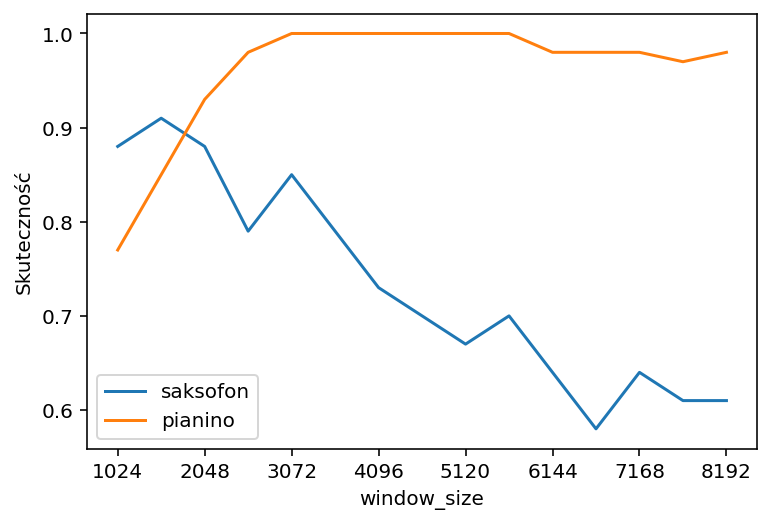

In [187]:
sax_ac = np.array(sax_ac).round(2)
piano_ac = np.array(piano_ac).round(2)

print(sax_ac)
print(piano_ac)

fig,ax = plt.subplots()
ax.plot(window_sizes, sax_ac, label="saksofon")
ax.plot(window_sizes, piano_ac, label="pianino")
ax.set_xticks(window_sizes[0::2])
ax.legend()
ax.set_xlabel("window_size")
ax.set_ylabel("Skuteczność")
plt.show()